### Introduction

#### Importing necessary libraries

In [122]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import glob
import os

from pylab import *
from PIL import Image 
import cv2 as cv

from keras.layers import Input, Dense, Lambda, Layer, Add, Multiply, Conv2D, MaxPooling2D, UpSampling2D, Flatten
from keras.models import Model, Sequential
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint

from sklearn.manifold import TSNE

#### Getting local directory and load image data

In [8]:
#Get current working directory
cwd = os.getcwd()

path = cwd[:-9] + "\\Images"                     
all_files = glob.glob(os.path.join(path, "*.png")) # OS independent
all_files.sort(key=os.path.getmtime) #sort by time created to get the same order of results

#### Get labels (climate zone) from file names

In [47]:
labels = np.empty((len(all_files), 1))

for i in range(0, len(all_files)):
    labels[i] = all_files[i].split('\\')[-1].split('_')[-2]

#### Crop, rescale and grayscale images; save resulting images in a numpy array

In [10]:
##First 456 pictures have different boundaries, so we crop them here separately

#Initial dimensions of the images, after cropping: in this case 745 x 745
init_height, init_width = 745, 745
#Target dimension, change this to the dimension you want
target_height, target_width = 240, 240
#Resize factors
fx, fy = (target_height / init_height), (target_width / init_width)
#Create an array to save arrays of images
Results_a = np.empty((456, target_height, target_width))

for i in range(0, 456):
    im = Image.open(all_files[i])
    im = im.crop((25,25,770,770))
    im = im.convert('L')
    im_resized = cv.resize(np.array(im), None, fx=fx, fy=fy, interpolation = cv.INTER_AREA)
    im_resized = im_resized / 255
    Results_a[i] = im_resized

In [11]:
##This is for the rest of the pictures

#Initial dimensions of the images, after cropping: in this case 610 x 610
init_height2, init_width2 = 610, 610
#Resize factors
fx2, fy2 = (target_height / init_height2), (target_width / init_width2)
#Create an array to save arrays of images
Results_b = np.empty((4728, target_height, target_width))

for i in range(4728):
    im = Image.open(all_files[i+456])
    im = im.crop((90, 90,700,700))
    im = im.convert('L')
    im_resized = cv.resize(np.array(im), None, fx=fx2, fy=fy2, interpolation = cv.INTER_AREA)
    im_resized = im_resized / 255
    Results_b[i] = im_resized

In [14]:
#Merge both result arrays
Results = np.vstack((Results_a, Results_b))
print('Result shape is:', Results.shape)

#Generate train and test sets
import random
a = random.sample(range(0, len(Results)), int(len(Results)*0.2))
np.random.shuffle(a)
mask = np.ones(len(Results), dtype=bool)
mask[a] = False

X_train = Results[mask].reshape(-1,240,240,1)
X_test = Results[a].reshape(-1,240,240,1)

print('Training set shape is:', X_train.shape)
print('Testing set shape is:', X_test.shape)
print('Total number of rows are:', (len(X_train)+len(X_test)))

Result shape is: (5184, 240, 240)
Training set shape is: (4148, 240, 240, 1)
Testing set shape is: (1036, 240, 240, 1)
Total number of rows are: 5184


#### Create the ZCA Whitening matrix (optional to test)

https://martin-thoma.com/zca-whitening/

https://en.wikipedia.org/wiki/Whitening_transformation

In [ ]:
def zca_whitening_matrix(X):
    """
    Function to compute ZCA whitening matrix (aka Mahalanobis whitening).
    INPUT:  X: [M x N] matrix.
        Rows: Variables
        Columns: Observations
    OUTPUT: ZCAMatrix: [M x M] matrix
    """
    # Covariance matrix [column-wise variables]: Sigma = (X-mu)' * (X-mu) / N
    sigma = np.cov(X, rowvar=True) # [M x M]
    # Singular Value Decomposition. X = U * np.diag(S) * V
    U,S,V = np.linalg.svd(sigma)
        # U: [M x M] eigenvectors of sigma.
        # S: [M x 1] eigenvalues of sigma.
        # V: [M x M] transpose of U
    # Whitening constant: prevents division by zero
    epsilon = 1e-5
    # ZCA Whitening matrix: U * Lambda * U'
    ZCAMatrix = np.dot(U, np.dot(np.diag(1.0/np.sqrt(S + epsilon)), U.T)) # [M x M]
    return ZCAMatrix

In [ ]:
X_train_zca = zca_whitening_matrix(X_train)
X_test_zca = zca_whitening_matrix(X_test)

#### Create the Convolutional Autoencoder (CAE) model

In [92]:
#Convolutional autoencoder
print('Input image is:', (target_height, target_width))
input_img = Input(shape=(target_height,target_width,1), name='Input')
layer1 = Conv2D(128, (1,1), activation='relu', padding='same', name='FullConv')(input_img)
pool1 = MaxPooling2D((2, 2), padding='same', name='MaxPooling1')(layer1)
encoder1 = Conv2D(64, (2, 2), activation='relu', padding='same', name='Encoder1')(pool1)
pool2 = MaxPooling2D((4, 4), padding='same', name='MaxPooling2')(encoder1)
encoder2 = Conv2D(32, (3, 3), activation='relu', padding='same', name='Encoder2')(pool2)

y = Conv2D(8, (2,2), activation='relu', padding='same', name='Encoded')(encoder2)
print(y.shape)

decoder1 = Conv2D(32, (3, 3), activation='relu', padding='same', name='Decoder1')(y)
upsample1 = UpSampling2D((2, 2), name='Upsampling1')(decoder1)
decoder2 = Conv2D(64, (2, 2), activation='relu', padding='same', name='Decoder2')(upsample1)
upsample2 = UpSampling2D((4, 4), name='Upsampling2')(decoder2)
decoder3 = Conv2D(128, (2, 2), activation='relu', padding='same', name='Decoder3')(upsample2)
upsample3 = UpSampling2D((1, 1), name='Upsampling3')(decoder3)
decoded = Conv2D(1, (2, 2), activation='sigmoid', padding='same', name='Decoded')(upsample3)
print(decoded.shape)

conv_autoencoder = Model(input_img, decoded)

encoder = Model(input_img, y)

conv_autoencoder.compile(optimizer='adadelta', loss='MSE')

Input image is: (240, 240)
(?, 30, 30, 8)
(?, 240, 240, 1)


#### Print a summary of the model

In [93]:
conv_autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 240, 240, 1)       0         
_________________________________________________________________
FullConv (Conv2D)            (None, 240, 240, 128)     256       
_________________________________________________________________
MaxPooling1 (MaxPooling2D)   (None, 120, 120, 128)     0         
_________________________________________________________________
Encoder1 (Conv2D)            (None, 120, 120, 64)      32832     
_________________________________________________________________
MaxPooling2 (MaxPooling2D)   (None, 30, 30, 64)        0         
_________________________________________________________________
Encoded (Conv2D)             (None, 30, 30, 8)         2056      
_________________________________________________________________
Decoder1 (Conv2D)            (None, 30, 30, 32)        2336      
__________

#### Fit the model on the data

In [94]:
conv_autoencoder.fit(X_train, X_train, epochs=5, batch_size=15, shuffle=True,
                     validation_data=(X_test, X_test),
                     callbacks=[TensorBoard(log_dir= cwd[:-9] + "ConvModels"),
                                EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5),
                                ModelCheckpoint(cwd[:-9] + "/Conv1.h5", save_best_only=True)])

Train on 4148 samples, validate on 1036 samples
Epoch 1/5
4148/4148 [==============================] - 114s 28ms/step - loss: 0.0251 - val_loss: 0.0096
Epoch 2/5
4148/4148 [==============================] - 113s 27ms/step - loss: 0.0075 - val_loss: 0.0062
Epoch 3/5
4148/4148 [==============================] - 114s 27ms/step - loss: 0.0053 - val_loss: 0.0046
Epoch 4/5
4148/4148 [==============================] - 114s 27ms/step - loss: 0.0046 - val_loss: 0.0044
Epoch 5/5
4148/4148 [==============================] - 115s 28ms/step - loss: 0.0042 - val_loss: 0.0042


#### Plot some decoded images and hidden layer encoded representations

In [95]:
decoded_imgs = conv_autoencoder.predict(X_train)
encoded_imgs = encoder.predict(X_train)

print(decoded_imgs.shape)
print(encoded_imgs.shape)

(4148, 240, 240, 1)
(4148, 30, 30, 8)


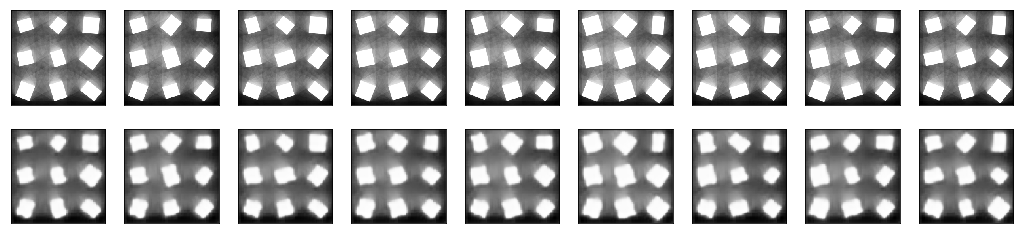

In [96]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(X_train[i].reshape(240, 240))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(240, 240))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.savefig(cwd[:-9] + "Conv1_Test.png")
plt.show()

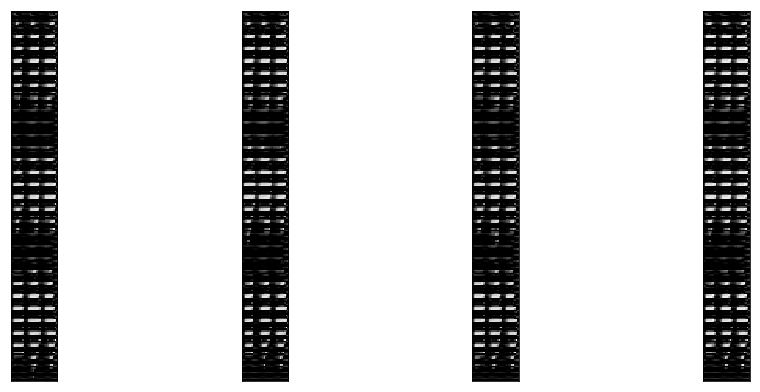

In [99]:
n = 5
plt.figure(figsize=(20, 15))
for i in range(1, n):
    # display encoded representations
    ax = plt.subplot(2, n, i + n)
    plt.imshow(encoded_imgs[i].reshape(30, 30 * 8).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.savefig(cwd[:-9] + "Conv1_Test_encoded.png")
plt.show()

#### Use the pretrained model for classification

##### Take only the encoder model and add a softmax (classification) layer

In [100]:
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 240, 240, 1)       0         
_________________________________________________________________
FullConv (Conv2D)            (None, 240, 240, 128)     256       
_________________________________________________________________
MaxPooling1 (MaxPooling2D)   (None, 120, 120, 128)     0         
_________________________________________________________________
Encoder1 (Conv2D)            (None, 120, 120, 64)      32832     
_________________________________________________________________
MaxPooling2 (MaxPooling2D)   (None, 30, 30, 64)        0         
_________________________________________________________________
Encoded (Conv2D)             (None, 30, 30, 8)         2056      
Total params: 35,144
Trainable params: 35,144
Non-trainable params: 0
_________________________________________________________________


In [101]:
encoder.layers[-1].outbound_nodes = []
encoder.outputs = [encoder.layers[-1].output]
output = encoder.get_layer('Encoded').output
output = Flatten()(output)
output = Dense(activation='softmax', units=3)(output)
classifier = Model(encoder.input, output)

In [102]:
classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 240, 240, 1)       0         
_________________________________________________________________
FullConv (Conv2D)            (None, 240, 240, 128)     256       
_________________________________________________________________
MaxPooling1 (MaxPooling2D)   (None, 120, 120, 128)     0         
_________________________________________________________________
Encoder1 (Conv2D)            (None, 120, 120, 64)      32832     
_________________________________________________________________
MaxPooling2 (MaxPooling2D)   (None, 30, 30, 64)        0         
_________________________________________________________________
Encoded (Conv2D)             (None, 30, 30, 8)         2056      
_________________________________________________________________
flatten_3 (Flatten)          (None, 7200)              0         
__________

##### Generate labels for training and test sets

In [103]:
y_train = labels[mask]
y_test = labels[a]

In [119]:
from keras.utils.np_utils import to_categorical
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

In [120]:
classifier.compile(optimizer='adadelta', loss='categorical_crossentropy')

In [121]:
classifier.fit(X_train, y_train_cat, epochs=5, batch_size=10, shuffle=True,
                     validation_data=(X_test, y_test_cat),
                     callbacks=[TensorBoard(log_dir= cwd[:-9] + "ConvModels"),
                                EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5),
                                ModelCheckpoint(cwd[:-9] + "/Conv1.h5", save_best_only=True)])

Train on 4148 samples, validate on 1036 samples
Epoch 1/5
4148/4148 [==============================] - 34s 8ms/step - loss: 0.0543 - val_loss: 2.9952e-04
Epoch 2/5
4148/4148 [==============================] - 34s 8ms/step - loss: 1.0294e-04 - val_loss: 2.1396e-05
Epoch 3/5
4148/4148 [==============================] - 35s 8ms/step - loss: 1.3414e-05 - val_loss: 6.7420e-06
Epoch 4/5
4148/4148 [==============================] - 34s 8ms/step - loss: 5.6037e-06 - val_loss: 4.6864e-06
Epoch 5/5
4148/4148 [==============================] - 34s 8ms/step - loss: 3.4611e-06 - val_loss: 2.8269e-06


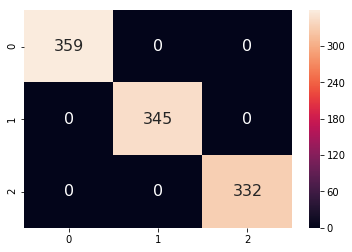

In [123]:
from sklearn.metrics import confusion_matrix
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred.argmax(axis=1))

#Plot confusion matrix to visualise performance
sns.heatmap(cm, fmt='d', annot=True,annot_kws={"size": 16})# font size
plt.show()